In [1]:
!pip install pytorch-lightning wandb --upgrade --quiet
!git clone https://github.com/benihime91/leaf-disease-classification-kaggle.git

Cloning into 'leaf-disease-classification-kaggle'...
remote: Enumerating objects: 119, done.
remote: Counting objects: 100% (119/119), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 119 (delta 64), reused 66 (delta 26), pack-reused 0
Receiving objects: 100% (119/119), 6.58 MiB | 9.02 MiB/s, done.
Resolving deltas: 100% (64/64), done.


In [2]:
import warnings
import os

os.chdir("/kaggle/working/leaf-disease-classification-kaggle/")
warnings.filterwarnings("ignore")

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
# --------------------------------
# IMPORT LIBRARIES
# --------------------------------
import pytorch_lightning as pl
import albumentations as A
from albumentations.pytorch import ToTensorV2
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torchvision
import logging
import argparse
import pandas as pd
import wandb

from lightning import LightningModel_resnext50_32x4d as LitModel
from lightning import LitDatatModule
from preprocess import Preprocessor
pd.set_option("display.max_colwidth", None)

# set up paths to the data directories
image_dir = "/kaggle/input/cassava-leaf-disease-classification/train_images"
csv_dir   = "/kaggle/input/cassava-leaf-disease-classification/train.csv"
json_dir  = "/kaggle/input/cassava-leaf-disease-classification/label_num_to_disease_map.json"

# set random seeds
random.seed(42)
pl.seed_everything(42)
torch.manual_seed(42)
np.random.seed(42)

# login to wandb: a74f67fd5fae293e301ea8b6710ee0241f595a63
! wandb login "a74f67fd5fae293e301ea8b6710ee0241f595a63"

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [4]:
# since we already have the fold dataset
fold_csv = "/kaggle/working/leaf-disease-classification-kaggle/fold_df.csv"
processor = Preprocessor(csv_dir, json_dir, image_dir, num_folds=5)
# set the dataframe of Preprocessor to the the fold_csv
df = pd.read_csv(fold_csv)
df.filePath = [os.path.join(image_dir, df.image_id[i]) for i in range(len(df))]
processor.dataframe = df
processor.dataframe.head()

,image_id,label,filePath,kfold
0,2615227158.jpg,4,/kaggle/input/cassava-leaf-disease-classification/train_images/2615227158.jpg,0
1,1277648239.jpg,3,/kaggle/input/cassava-leaf-disease-classification/train_images/1277648239.jpg,0
2,2305895487.jpg,3,/kaggle/input/cassava-leaf-disease-classification/train_images/2305895487.jpg,0
3,336299725.jpg,2,/kaggle/input/cassava-leaf-disease-classification/train_images/336299725.jpg,0
4,1951270318.jpg,2,/kaggle/input/cassava-leaf-disease-classification/train_images/1951270318.jpg,0


In [5]:
# -------------------------------
# Grab one FOLD
# -------------------------------
fold_num = 0
trainFold, valFold = processor.get_fold(fold_num)
testFold, valFold  = train_test_split(valFold, stratify=valFold.label, test_size=0.5) 

trainFold.reset_index(drop=True, inplace=True)
testFold.reset_index(drop=True, inplace=True)
valFold.reset_index(drop=True, inplace=True)

In [6]:
print("Length of train data:", len(trainFold))
print("Length of test data:", len(testFold))
print("Length of valid data:", len(valFold))

Length of train data: 17117
Length of test data: 2140
Length of valid data: 2140


In [14]:
# weights = processor.weights
# weights = torch.tensor(list(weights.values()))
# weights = 1 - weights
# weights

In [8]:
label_map = processor.label_map
label_map

{0: 'Cassava Bacterial Blight (CBB)',
 1: 'Cassava Brown Streak Disease (CBSD)',
 2: 'Cassava Green Mottle (CGM)',
 3: 'Cassava Mosaic Disease (CMD)',
 4: 'Healthy'}

In [9]:
def imshow(image, targets):
    """Imshow for Tensor."""
    grid = torchvision.utils.make_grid(image, normalize=True, nrow=4).permute(1, 2, 0).data.numpy()
    grid = np.array(grid * 255., dtype=np.uint)
    classes = targets.data.numpy()
    plt.figure(figsize=(15, 10))
    plt.axis("off")
    plt.imshow(grid)
    plt.title([label_map[i] for i in classes]);

In [10]:
image_dim = 224 # dimension of the image after resize

# Specify TRANSFORATIONS for TRAIN/VAL/TEST DATALOADERS
train_transformations = A.Compose([
    A.Rotate(p=0.5, limit=60),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.CLAHE(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.Resize(image_dim, image_dim, always_apply=True),
    A.Normalize(always_apply=True),
    ToTensorV2(always_apply=True),

])

valid_transformations = A.Compose([
    A.Resize(image_dim, image_dim, always_apply=True),
    A.Normalize(always_apply=True),
    ToTensorV2(always_apply=True)
])

test_transformations = valid_transformations

albu_transforms = {
    "train": train_transformations, 
    "valid": valid_transformations,
    "test" : test_transformations,
}

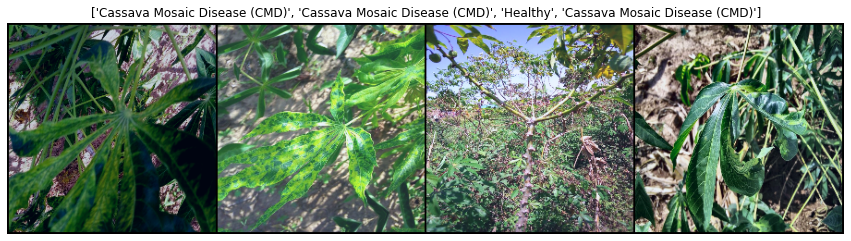

In [11]:
# Init DataModule
batch_size  = 128
data_module = LitDatatModule(trainFold, valFold, testFold, batch_size, albu_transforms, num_workers=3, pin_memory=True)
data_module.setup()

# grab samples to log predictions on
samples = next(iter(data_module.val_dataloader()))

# view sample images
ims, targs = next(iter(data_module.train_dataloader()))
imshow(ims[:4], targs[:4])

In [12]:
# ----------------------------------
# TRAINING ARGUMENTS
# ------------------------------------
num_epochs = 20
steps_per_epoch = len(data_module.train_dataloader())
total_steps = num_epochs * steps_per_epoch

learning_rate = 0.01
weight_decay = 0.001

output_dims = len(label_map)

# Parse arguments
parser = argparse.ArgumentParser()
parser.add_argument("--learning_rate", type=float, default=learning_rate, help="learning rate")
parser.add_argument("--weight_decay",  type=float, default=weight_decay, help="weight_decay")
parser.add_argument("--total_steps",   type=int, default=total_steps, help="total steps to train for")
parser.add_argument("--output_dims",   type=int, default=output_dims, help="number of output classes")
args, _ = parser.parse_known_args()

logger = logging.getLogger("lightning")
logger.info(f"num_epochs: {num_epochs}")
logger.info(f"steps_per_epoch: {steps_per_epoch}")
logger.info(f"total_steps: {total_steps}")
logger.info(f"learning_rate: {learning_rate}")
logger.info(f"weight_decay: {weight_decay}")
logger.info(f"output_dims: {output_dims}")

num_epochs: 20
steps_per_epoch: 134
total_steps: 2680
learning_rate: 0.01
weight_decay: 0.001
output_dims: 5


In [13]:
# -----------------------------------
# LIGHTNING TRAINER
# ------------------------------------
class ImagePredictionLogger(pl.Callback):
    def __init__(self, val_samples, num_samples = 16):
        """
        Upon finishing training log num_samples number
        of images and their predictions to wandb
        """
        super().__init__()
        self.val_imgs, self.val_labels = val_samples
        self.val_imgs   = self.val_imgs[:num_samples]
        self.val_labels = self.val_labels[:num_samples]
          
    def on_fit_end(self, trainer, pl_module):
        val_imgs = self.val_imgs.to(device=pl_module.device)
        logits = pl_module(val_imgs)
        preds = torch.argmax(logits, -1)
        examples = [wandb.Image(x, caption=f"Pred:{pred}, Label:{y}") for x, pred, y in zip(val_imgs, preds, self.val_labels)]
        trainer.logger.experiment.log({"examples": examples})

# Init trainer callbacks
PATH = "/kaggle/working/"
chkpt = pl.callbacks.ModelCheckpoint(filepath=PATH, monitor="val_loss", save_top_k=1, mode="min")

lr_monitor = pl.callbacks.LearningRateMonitor(logging_interval="step")

run_name = f"resnext50_32x4d|fold={fold_num}"
wb_logger = pl.loggers.WandbLogger(project="kaggle-leaf-disease", name=run_name)

stopping = pl.callbacks.EarlyStopping(monitor="val_loss", patience=3, mode="min")

cbs = [lr_monitor, ImagePredictionLogger(samples), stopping]

# Init trainer
trainer = pl.Trainer(
    precision=16,
    gpus=1,
    logger=wb_logger,
    checkpoint_callback=chkpt,
    callbacks=cbs,
    max_steps=total_steps,
    log_every_n_steps=20
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.


In [ ]:
# -------------------------------
# INSTANTIATE AND FIT MODEL  :
# --------------------------------
# Init model
model = LitModel(**vars(args), class_weights=None, hidden_dims=512) # train without weights for loss_fn
model.example_input_array = torch.zeros_like(ims)

# Freeze the feature extractor/base of the model
model.freeze_classifier()

# Log model topology 
wb_logger.watch(model.net)
wb_logger.log_hyperparams(vars(args))

# Pass the datamodule as arg to trainer.fit to override model hooks :)
trainer.fit(model, datamodule=data_module)

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth


wandb: Currently logged in as: ayushman (use `wandb login --relogin` to force relogin)



  | Name          | Type             | Params | In sizes           | Out sizes  
--------------------------------------------------------------------------------------
0 | classifier    | ResNet           | 25 M   | [128, 3, 224, 224] | [128, 1000]
1 | hidden_layers | Sequential       | 518 K  | [128, 1000]        | [128, 5]   
2 | net           | Sequential       | 25 M   | [128, 3, 224, 224] | [128, 5]   
3 | loss_fn       | CrossEntropyLoss | 0      | ?                  | ?          


In [ ]:
# Compute metrics on test dataset
trainer.test(model, datamodule=data_module)

In [ ]:
weightsPath = f"/kaggle/working/weights_fold={fold_num}.pt"

torchmodel = model.net
# save torch model state dict
torch.save(torchmodel.state_dict(), weightsPath)

In [ ]:
# cross-check saved file
from torch import nn
from torchvision import models

device = torch.device("cuda:0")

# assemble classification network
classifier = models.resnext50_32x4d(pretrained=True, progress=True)
base_output_dims = classifier.fc.out_features
hidden_dims = 512

hidden_layers = nn.Sequential(
    nn.BatchNorm1d(base_output_dims),
    nn.Dropout(0.25),
    nn.ReLU(inplace=True),
    nn.Linear(base_output_dims, hidden_dims),
    nn.BatchNorm1d(hidden_dims),
    nn.Dropout(0.25),
    nn.ReLU(inplace=True),
    nn.Linear(hidden_dims, output_dims)
)

net = nn.Sequential(classifier, hidden_layers)

# load saved model weights
state_dict = torch.load(weightsPath, map_location=device)
# load the torch state dict to the model
net.load_state_dict(state_dict)

In [ ]:
# save the weights to wandb
# WandB – Save the model checkpoint. This automatically saves a file to the cloud and associates it with the current run.
wandb.save(weightsPath)
# finish run
wandb.finish()